In [1]:
import os
import platform
import random
import shutil
import sys

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn.metrics
import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
from tqdm import tqdm_notebook as tqdm
import keras 
%matplotlib inline
random.seed(0)

from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

Using TensorFlow backend.


In [2]:
def accuracy_plot(model, title): 
    plt.plot(model.history.history['acc'])
    plt.plot(model.history.history['val_acc'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def loss_plot(model, title): 
    plt.plot(model.history.history['loss'])
    plt.plot(model.history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
# plotting

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics

def confusion_plot(y_true_labels, y_pred_labels, title, class_names): 

    def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("All data confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False,
                          title=title)

    plt.show()
    
    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title=title)

    plt.show()

In [3]:
# read in train, val, test dfs 
data_dir = './data/'
# diff sheets, so need to read in 
file_name = data_dir + 'processed_binary_data' 
train_df = pd.read_csv(file_name+'_train.csv', sep = ',').reset_index()
test_df = pd.read_csv(file_name+'_test.csv', sep = ',').reset_index()
train_df.head(5)

,index,Unnamed: 0,Unnamed: 0.1,On-Target Site,Off-Target Site,Score,Encoded Seqs
0,0,0,0,AAATGAGAAGAAGAGGCACAGGG,AAAAGAGAAGCTGAGGCACAGGG,1.0,KKKREKEKKEZREKEEPKPKEEE
1,1,1,1,AAATGAGAAGAAGAGGCACAGGG,AAACGAGAAGAAGAGGCATAGGG,1.0,KKKMEKEKKEKKEKEEPKMKEEE
2,2,2,2,AAATGAGAAGAAGAGGCACAGGG,AAACGAGAAGAAGCTGCACATGG,1.0,KKKMEKEKKEKKEZJEPKPKJEE
3,3,4,4,AAATGAGAAGAAGAGGCACAGGG,AAATCATATGAAGAGGCACAAGG,1.0,KKKLHKJKREKKEKEEPKPKYEE
4,4,5,5,AAATGAGAAGAAGAGGCACAGGG,AAATGAGAAAAATAGGCAGAGGG,1.0,KKKLEKEKKYKKJKEEPKHKEEE


In [4]:
# check lengths -- confirm all are same when comparing across datasets
seq_len = len(train_df['On-Target Site'][0])
print('Guide length: ', seq_len) # NOTE: WT seq is the reverse complement of guide 
print('Off-target:', len(train_df['Off-Target Site'][0]))

Guide length:  23
Off-target: 23


In [5]:
from pysster.One_Hot_Encoder import One_Hot_Encoder

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
new_alph_map = {'AA': 'K', 'AT': 'R', 'AC': 'Z', 'AG': 'Y', 'TT': 'L', 'TC': 'M', 'TG':'J', 
                'CC': 'P', 'CG':'H', 'GG': 'E'}

new_alph = list(new_alph_map.values())

# one-hot encode
#modified code from Luis to get correct format for TPOT w/ my alphabet
one = One_Hot_Encoder(''.join(new_alph))
    
def _get_one_hot_encoding(seq):
    one_hot_seq = one.encode(seq)                         
    encoded_seq = np.argmax((one_hot_seq), axis=1) 
    return encoded_seq
    #return pd.get_dummies(
      #list(seq) + new_alph)[:-len(new_alph)].as_matrix().transpose()

# now convert the data into one_hot_encoding 
input_col_name = 'Encoded Seqs'
train_data = np.stack(
    [_get_one_hot_encoding(s) for s in train_df[input_col_name]]).astype(np.float32)
#val_data = np.stack(
    #[_get_one_hot_encoding(s) for s in val_df[input_col_name]]).astype(np.float32)
test_data = np.stack(
    [_get_one_hot_encoding(s) for s in test_df[input_col_name]]).astype(np.float32)

In [6]:
alph_len = len(new_alph)

from keras.utils import to_categorical

output_bin_col_name = 'Score'; 

# NOTE: need one-hot encoding of the labels 
train_bins = to_categorical(np.array(train_df[output_bin_col_name].astype(np.float32)))
#val_bins = to_categorical(np.array(val_df[output_bin_col_name].astype(np.float32)))
test_bins = to_categorical(np.array(test_df[output_bin_col_name].astype(np.float32)))

print('done')

done


In [7]:
from keras.layers.core import Permute
from keras import backend as K
from keras.engine.topology import Layer
import numpy as np
import keras as keras
from keras.callbacks import TensorBoard
from keras import metrics as metrics
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Embedding
from keras.optimizers import SGD
from keras.regularizers import l2

def embed_model_ablate(embed_dim, hidden_layers, l2_coeff, dropout_rate):
    X_in = Input(shape=(seq_len,),dtype='float32')
    E = Embedding(alph_len,embed_dim,input_length=seq_len)(X_in)
    H = Flatten()(E)
#     H = Dropout(dropout_rate)(H)
#     for h in hidden_layers: 
#         H = Dense(h, activation='relu', activity_regularizer = l2(l2_coeff))(H)
#         H = Dropout(dropout_rate)(H)
    H = Dense(2,activation="softmax",name='preds')(H)
    model = Model(inputs=[X_in], outputs=H)
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])#[precision,recall])#metrics=[sensitivity, specificity])
    return model

In [8]:
model = embed_model_ablate(embed_dim=5, hidden_layers=(50,), l2_coeff = 0.0, dropout_rate = 0.0)

X = train_data
y = train_bins
num_epochs = 20
#early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, verbose=0, mode='auto', baseline=None)
initial_loss, initial_accuracy = model.evaluate(X, y)
print("Epoch 0: Loss ", initial_loss, " accuracy ", initial_accuracy)
model.fit(X, y, epochs=num_epochs, batch_size=128)#,validation_data=(val_data, val_bins))#,callbacks=[early_stopping])

327078/327078 [==============================] - 2s 6us/step
Epoch 0: Loss  0.6987893799210717  accuracy  0.42277071524241805
Epoch 1/20
327078/327078 [==============================] - 2s 5us/step - loss: 0.0272 - acc: 0.9969
Epoch 2/20
327078/327078 [==============================] - 2s 5us/step - loss: 0.0092 - acc: 0.9983
Epoch 3/20
327078/327078 [==============================] - 2s 5us/step - loss: 0.0051 - acc: 0.9986
Epoch 4/20
327078/327078 [==============================] - 2s 5us/step - loss: 0.0044 - acc: 0.9987
Epoch 5/20
327078/327078 [==============================] - 2s 5us/step - loss: 0.0043 - acc: 0.9987
Epoch 6/20
327078/327078 [==============================] - 2s 5us/step - loss: 0.0042 - acc: 0.9987
Epoch 7/20
327078/327078 [==============================] - 2s 5us/step - loss: 0.0041 - acc: 0.9988
Epoch 8/20
327078/327078 [==============================] - 2s 5us/step - loss: 0.0040 - acc: 0.9988
Epoch 9/20
327078/327078 [==============================] - 2s 5us

AUC: 0.7203497148547507
Accuracy: 0.9983643376788243 

F1: 0.7636748814522705 

Confusion matrix, without normalization
[[81715    39]
 [   95    75]]


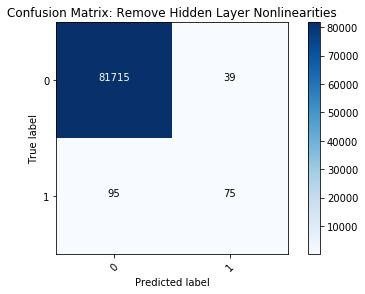

All data confusion matrix
[[1.00e+00 4.77e-04]
 [5.59e-01 4.41e-01]]


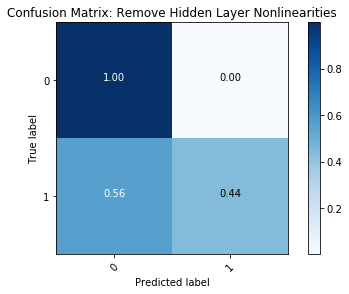

Average precision-recall score: 0.82


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.82')

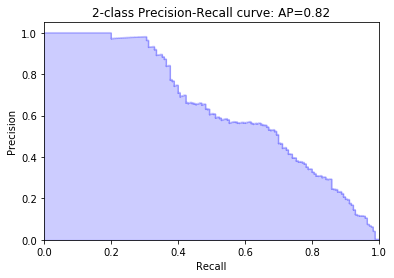

In [9]:
specs = 'Remove Hidden Layer Nonlinearities'

X_new = test_data
y_true = test_bins
y_pred = model.predict(X_new)

y_true_labels = np.argmax(y_true, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1) 
from sklearn.metrics import roc_auc_score

print('AUC:', roc_auc_score(y_true_labels, y_pred_labels))

print('Accuracy:', sklearn.metrics.accuracy_score(y_true_labels, y_pred_labels), '\n')
print('F1:', sklearn.metrics.f1_score(y_true_labels,y_pred_labels, average='macro'),'\n')

#accuracy_plot(model, 'Accuracy: ' + specs)
#loss_plot(model, 'Loss: ' + specs)

class_names = ['0', '1']
confusion_plot(y_true_labels, y_pred_labels, 'Confusion Matrix: ' + specs, class_names)

# from TAs on piazza: use precision-recall, ROC can be misleading 
# modified code from sklearn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html
# and referenced: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

average_precision = average_precision_score(y_true, y_pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, _ = precision_recall_curve(y_true_labels, y_pred[:,1]) # look at positive class prob

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [10]:
def embed_model_ablate(embed_dim, hidden_layers, l2_coeff, dropout_rate):
    X_in = Input(shape=(seq_len,),dtype='float32')
    E = Embedding(alph_len,1,input_length=seq_len)(X_in)
    H = Flatten()(E)
    H = Dropout(dropout_rate)(H)
    for h in hidden_layers: 
        H = Dense(h, activation='relu', activity_regularizer = l2(l2_coeff))(H)
        H = Dropout(dropout_rate)(H)
    H = Dense(2,activation="softmax",name='preds')(H)
    model = Model(inputs=[X_in], outputs=H)
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])#[precision,recall])#metrics=[sensitivity, specificity])
    return model

In [11]:
model2 = embed_model_ablate(embed_dim=5, hidden_layers=(50,), l2_coeff = 0.0, dropout_rate = 0.0)

X = train_data
y = train_bins
num_epochs = 20
#early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, verbose=0, mode='auto', baseline=None)
initial_loss, initial_accuracy = model2.evaluate(X, y)
print("Epoch 0: Loss ", initial_loss, " accuracy ", initial_accuracy)
model2.fit(X, y, epochs=num_epochs, batch_size=128)#,validation_data=(val_data, val_bins))#,callbacks=[early_stopping])

327078/327078 [==============================] - 2s 7us/step
Epoch 0: Loss  0.6872907566511353  accuracy  0.7097710637829509
Epoch 1/20
327078/327078 [==============================] - 2s 6us/step - loss: 0.0234 - acc: 0.9981
Epoch 2/20
327078/327078 [==============================] - 2s 5us/step - loss: 0.0065 - acc: 0.9984
Epoch 3/20
327078/327078 [==============================] - 2s 5us/step - loss: 0.0044 - acc: 0.9987
Epoch 4/20
327078/327078 [==============================] - 2s 5us/step - loss: 0.0043 - acc: 0.9987
Epoch 5/20
327078/327078 [==============================] - 2s 5us/step - loss: 0.0042 - acc: 0.9988
Epoch 6/20
327078/327078 [==============================] - 2s 5us/step - loss: 0.0041 - acc: 0.9988
Epoch 7/20
327078/327078 [==============================] - 2s 5us/step - loss: 0.0041 - acc: 0.9988
Epoch 8/20
327078/327078 [==============================] - 2s 5us/step - loss: 0.0040 - acc: 0.9988
Epoch 9/20
327078/327078 [==============================] - 2s 5us/

AUC: 0.682151116189314
Accuracy: 0.9982788926321957 

F1: 0.7335312902722395 

Confusion matrix, without normalization
[[81721    33]
 [  108    62]]


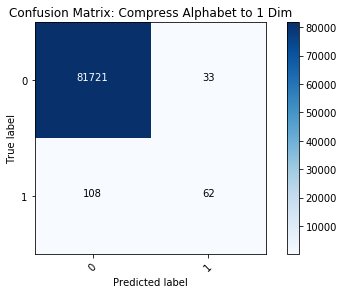

All data confusion matrix
[[1.00e+00 4.04e-04]
 [6.35e-01 3.65e-01]]


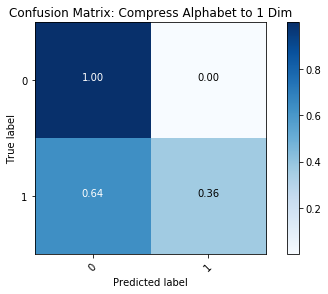

Average precision-recall score: 0.78


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.78')

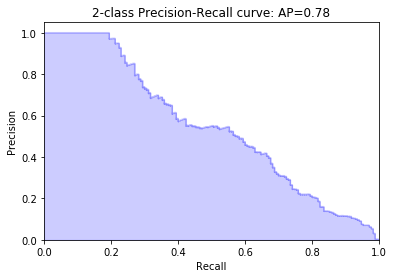

In [12]:
specs = 'Compress Alphabet to 1 Dim'

X_new = test_data
y_true = test_bins
y_pred = model2.predict(X_new)

y_true_labels = np.argmax(y_true, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1) 
from sklearn.metrics import roc_auc_score

print('AUC:', roc_auc_score(y_true_labels, y_pred_labels))

print('Accuracy:', sklearn.metrics.accuracy_score(y_true_labels, y_pred_labels), '\n')
print('F1:', sklearn.metrics.f1_score(y_true_labels,y_pred_labels, average='macro'),'\n')

#accuracy_plot(model, 'Accuracy: ' + specs)
#loss_plot(model, 'Loss: ' + specs)

class_names = ['0', '1']
confusion_plot(y_true_labels, y_pred_labels, 'Confusion Matrix: ' + specs, class_names)

# from TAs on piazza: use precision-recall, ROC can be misleading 
# modified code from sklearn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html
# and referenced: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

average_precision = average_precision_score(y_true, y_pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, _ = precision_recall_curve(y_true_labels, y_pred[:,1]) # look at positive class prob

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

[<keras.engine.input_layer.InputLayer object at 0x130e5fc50>, <keras.layers.embeddings.Embedding object at 0x130e5fc18>, <keras.layers.core.Flatten object at 0x130440b00>, <keras.layers.core.Dropout object at 0x130e5f128>, <keras.layers.core.Dense object at 0x130e5f198>, <keras.layers.core.Dropout object at 0x130e6fcc0>, <keras.layers.core.Dense object at 0x130e5fba8>]


<BarContainer object of 10 artists>

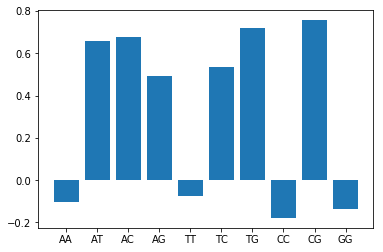

In [13]:
# look at the learned weights to viz embedding of new alphabet
weight_matrix = model2.layers[1].get_weights()[0]
weights = pd.DataFrame(weight_matrix)
print(model2.layers)
import seaborn as sns
reverse_map = {v:k for k,v in new_alph_map.items()}
plt.bar([reverse_map[letter] for letter in new_alph], [w for w in weights[0]])#,yticklabels=[reverse_map[letter] for letter in new_alph])

In [14]:
# shockingly, in only one dimension, learns that non-mutations are different (encodes w/ negative value)!!!!
# is this just a function of frequency? b/c more often occurs 
# but, this model performs poorly. must need additional dimensions to encode the differences across point mutations (mismatches)